# Timbre transfer FM



In [1]:
USE_PRIVATE_DISTRO = True

DRIVE_BASE_DIR = '/content/drive/MyDrive/SMC 10/DDSP-10/' 
DRIVE_DISTRO = DRIVE_BASE_DIR + 'dist/ddsp-1.2.0.tar.gz'

if USE_PRIVATE_DISTRO:
    print("[INFO] Using private distro.")
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -qU "$DRIVE_DISTRO"
else:
    !pip install -qU ddsp

import warnings
import gin

import tensorflow as tf

%reload_ext tensorboard
import tensorboard as tb
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from ddsp.colab.colab_utils import specplot
from ddsp.colab.colab_utils import play
from ddsp.training import data
from ddsp.training import models
from ddsp import core

[INFO] Using private distro.
Mounted at /content/drive
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 215kB 46.0MB/s 
     |████████████████████████████████| 3.6MB 50.5MB/s 
     |████████████████████████████████| 686kB 43.9MB/s 
     |████████████████████████████████| 3.9MB 44.1MB/s 
     |████████████████████████████████| 378kB 51.6MB/s 
     |████████████████████████████████| 5.6MB 10.8MB/s 
     |████████████████████████████████| 20.2MB 7.1MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 


#### Configuration

In [2]:
SAMPLE_RATE = 16000
DURATION = 4
FRAME_RATE = 250

TIME_STEPS = FRAME_RATE * DURATION
N_SAMPLES = SAMPLE_RATE * DURATION

UNITS = 256

INSTRUMENT = 'violin'

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

OUTPUT_FOLDER = 'fm_timbretrans_02_ar_fixed' #@param {type: "string"}

DRIVE_CHECKPOINTS_DIR = DRIVE_BASE_DIR + 'audio/' + OUTPUT_FOLDER + '/' + \
                         INSTRUMENT + '_checkpoints_'+str(UNITS)+'units/'

DRIVE_TFRECORD_PATTERN = DRIVE_BASE_DIR + 'audio/' + OUTPUT_FOLDER + '/' + \
                         INSTRUMENT + '_dataset/train.tfrecord*'

!mkdir -p "$DRIVE_CHECKPOINTS_DIR"

#### Start Tensorboard

In [ ]:
tb.notebook.start('--logdir "{}"'.format(DRIVE_CHECKPOINTS_DIR))

#### Train the model

In [ ]:
!ddsp_run \
  --mode=train \
  --alsologtostderr \
  --stop_at_nan \
  --save_dir="$DRIVE_CHECKPOINTS_DIR" \
  --gin_file=models/fm_violin.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param="TFRecordProvider.file_pattern='$DRIVE_TFRECORD_PATTERN'" \
  --gin_param="TFRecordProvider.sample_rate=$SAMPLE_RATE" \
  --gin_param="TFRecordProvider.frame_rate=$FRAME_RATE" \
  --gin_param="TFRecordProvider.example_secs=$DURATION" \
  --gin_param="RnnFcDecoder.rnn_channels=$UNITS" \
  --gin_param="RnnFcDecoder.ch=$UNITS" \
  --gin_param="FrequencyModulation.n_samples=$N_SAMPLES" \
  --gin_param="FrequencyModulation.sample_rate=$SAMPLE_RATE" \
  --gin_param="FrequencyModulation.ar_scale=True" \
  --gin_param="FrequencyModulation.index_scale=True" \
  --gin_param="train_util.train.batch_size=16" \
  --gin_param="train_util.train.num_steps=30000" \
  --gin_param="train_util.train.steps_per_save=100" \
  --gin_param="train_util.train.steps_per_summary=50" \
  --gin_param="Trainer.checkpoints_to_keep=2" \
  --gin_param="Trainer.learning_rate=0.0001" \
  --gin_param="FilteredNoise.n_samples=$N_SAMPLES" \
  --early_stop_loss_value=4 \

#### Load pretrained model

In [17]:
data_provider_eval = data.TFRecordProvider(DRIVE_TFRECORD_PATTERN, 
                                           sample_rate=SAMPLE_RATE,
                                           frame_rate=FRAME_RATE,
                                           example_secs=DURATION)
dataset_eval = data_provider_eval.get_batch(batch_size=1, shuffle=True, repeats=-1)
dataset_eval_iter = iter(dataset_eval)

gin_file = DRIVE_CHECKPOINTS_DIR + 'operative_config-0.gin'
gin.parse_config_file(gin_file)

model = models.Autoencoder()
model.restore(DRIVE_CHECKPOINTS_DIR)

# for f in range(12):
#   frame = next(dataset_eval_iter)

Original Audio


Full reconstruction


Only fm


Only filtered_noise


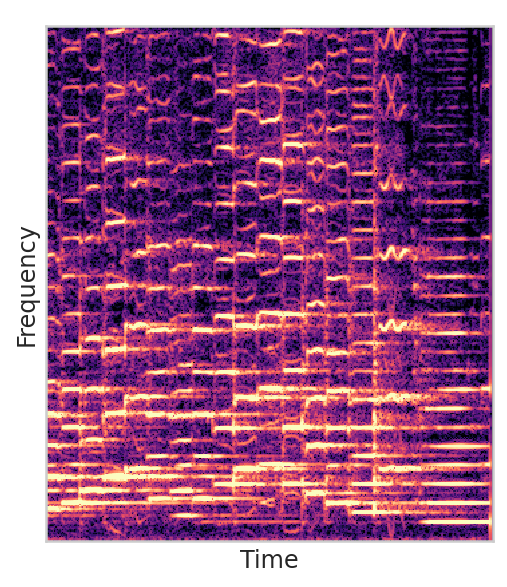

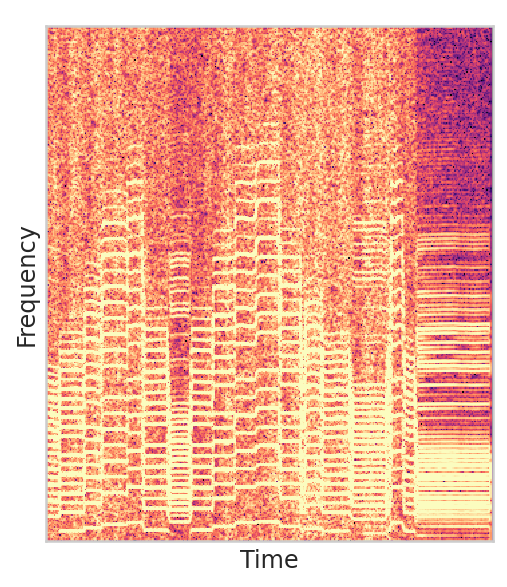

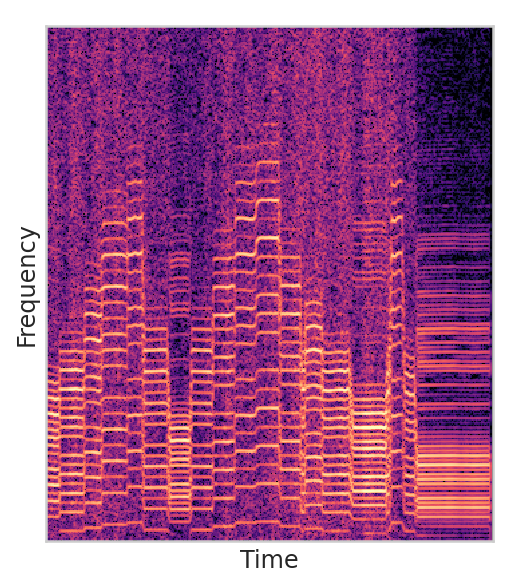

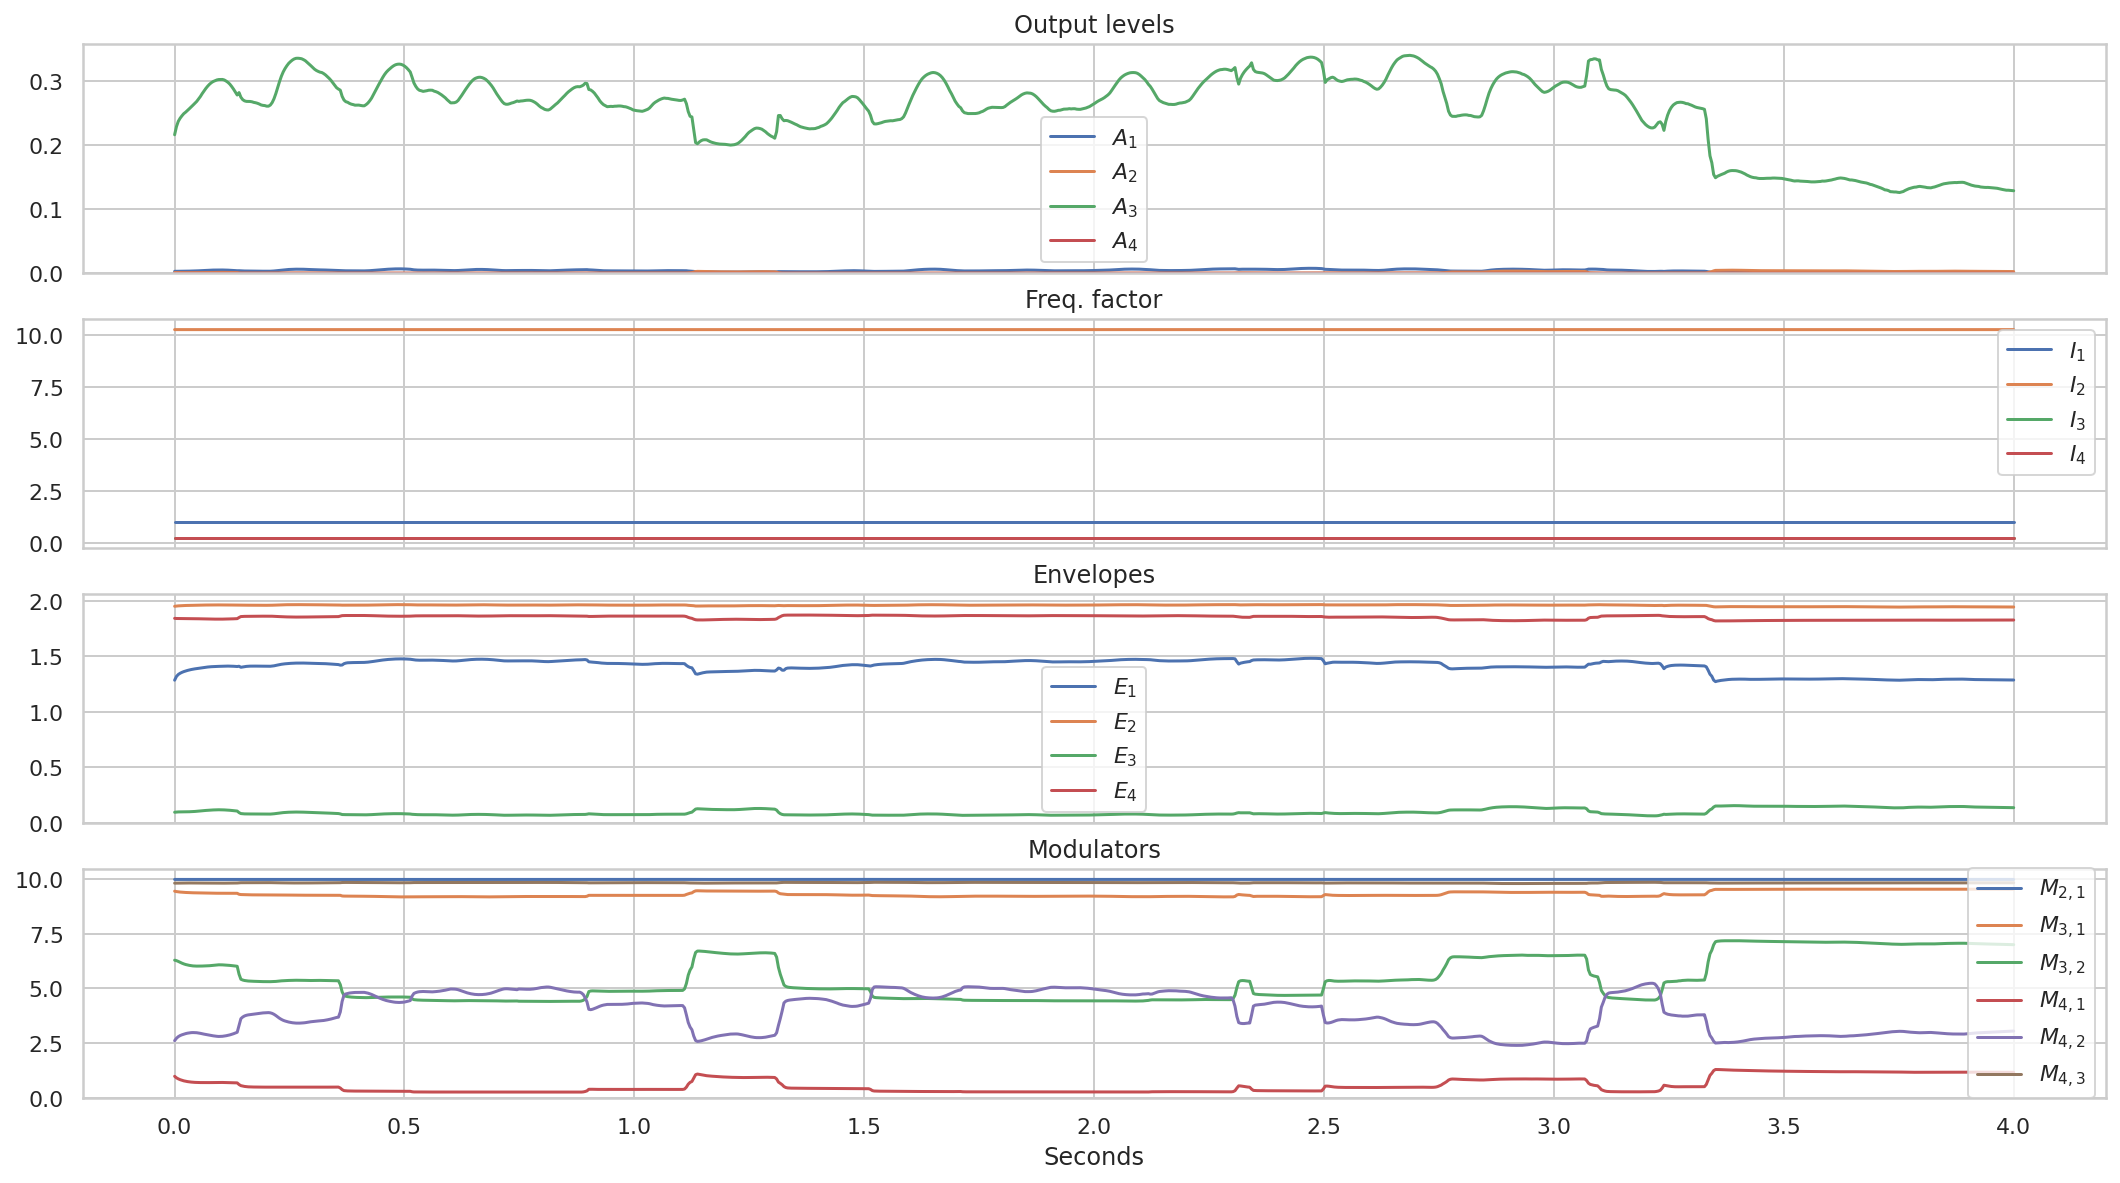

In [123]:
# frame = next(dataset_eval_iter)
audio_baseline = frame['audio']

controls = model(frame, training=False)
audio_full = model.get_audio_from_outputs(controls)
audio_full /= tf.reduce_max(audio_full[0,:], axis=0).numpy()*1.5

print('Original Audio')
play(audio_baseline, sample_rate=SAMPLE_RATE)

print('Full reconstruction')
play(audio_full, sample_rate=SAMPLE_RATE)

for synth in ['harmonic', 'fm', 'filtered_noise']:
  if synth in controls:
    print('Only ' + synth)
    play(controls[synth]['signal'], sample_rate=SAMPLE_RATE)

specplot(audio_baseline)
specplot(audio_full)
specplot(controls['fm']['signal'])

c = controls['fm']['controls']

x = np.linspace(0,DURATION,TIME_STEPS)

f, ax = plt.subplots(4, 1, figsize=(15, 8), sharex=True, )
# f.suptitle('Inferred controls', fontsize=14)
plt.tight_layout()

ax[0].plot(x,c['op1'][0,:,0])
ax[0].plot(x,c['op2'][0,:,0])
ax[0].plot(x,c['op3'][0,:,0])
ax[0].plot(x,c['op4'][0,:,0])
ax[0].legend(['$A_1$','$A_2$','$A_3$','$A_4$'])
ax[0].set_title('Output levels')
ax[0].set_ylim(0)

# *c['f0'][0,:,0]
ax[1].plot(x,c['op1'][0,:,1])
ax[1].plot(x,c['op2'][0,:,1])
ax[1].plot(x,c['op3'][0,:,1])
ax[1].plot(x,c['op4'][0,:,1])
ax[1].legend(['$I_1$','$I_2$','$I_3$','$I_4$'])
ax[1].set_title('Freq. factor')

ax[2].plot(x,c['op1'][0,:,2])
ax[2].plot(x,c['op2'][0,:,2])
ax[2].plot(x,c['op3'][0,:,2])
ax[2].plot(x,c['op4'][0,:,2])
ax[2].legend(['$E_1$','$E_2$','$E_3$','$E_4$'])
ax[2].set_title('Envelopes')
ax[2].set_ylim(0)


for mod in range(6):
  ax[3].plot(x,c['modulators'][0,:,mod])
ax[3].legend(['$M_{2,1}$','$M_{3,1}$','$M_{3,2}$','$M_{4,1}$','$M_{4,2}$','$M_{4,3}$'], loc='center right')
ax[3].set_ylim(0)
ax[3].set_title('Modulators')
ax[3].set_xlabel('Seconds')
f.show()

In [ ]:
raise SystemExit("Stop right there!")

In [86]:
from ddsp.synths import FrequencyModulation

fm = FrequencyModulation(n_samples=N_SAMPLES,
                                   sample_rate=SAMPLE_RATE,
                                   amp_scale_fn=None)


### Individual contributions

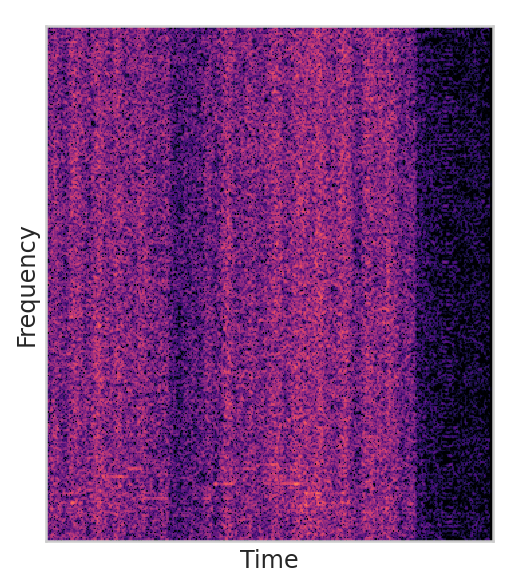

In [132]:
c = controls['fm']['controls'].copy()

op_noamp = np.ones_like(c['op1'])
op_noamp[:,:,0] = op_noamp[:,:,0]*0

# c['op1'] = tf.convert_to_tensor(op_noamp * c['op1'].numpy())
c['op2'] = tf.convert_to_tensor(op_noamp * c['op2'].numpy())
c['op3'] = tf.convert_to_tensor(op_noamp * c['op3'].numpy())
c['op4'] = tf.convert_to_tensor(op_noamp * c['op4'].numpy())

audio_fm = fm(c['f0'], c['op1'], c['op2'], c['op3'], c['op4'], c['modulators'])
play(audio_fm, sample_rate=SAMPLE_RATE, autoplay=False)

specplot(audio_fm)